# TileDB Presto Connector Demo

This notebook will demostrate the TileDB connector for Presto. Sample NYSE quote data is used for this demostration (see [demo prerequisites](https://github.com/TileDB-Inc/TileDB-Notebooks/blob/master/Presto_Demo/README.md))

In [65]:
%matplotlib inline
import pandas as pd
import numpy as np
import sys
import prestodb

Adjust the S3 bucket to the one you ingested the array in the prerequisites steps.

In [66]:
s3_bucket = 's3://your_bucket_here/tiledb_arrays/'
quote_uri = s3_bucket + 'quote_20180730'

Set the AWS access keys in order to access the array on the S3 bucket.

In [67]:
AWS_ACCESS_KEY_ID=xxxx
AWS_SECRET_ACCESS_KEY=yyyy

Connect to a local running Presto instance:

In [68]:
conn=prestodb.dbapi.connect(
    host='127.0.0.1',
    port=8080,
    user='demo',
    catalog='tiledb',
    schema='tiledb',
    session_properties = {
        'tiledb.aws_access_key_id': AWS_ACCESS_KEY_ID,
        'tiledb.aws_secret_access_key': AWS_SECRET_ACCESS_KEY
    }
)
cur = conn.cursor()
cur.execute('SELECT * FROM system.runtime.nodes')
rows = cur.fetchall()
pd.DataFrame(rows, columns=("node_id", "http_uri", "node_version", "coordinator", "state"))

,node_id,http_uri,node_version,coordinator,state
0,presto-coordinator,http://172.17.0.2:8080,0.211,True,active


Describe a TileDB array inside Presto. The TileDB schema is translated to Presto tabular format. Arrays can be accessed directly by URI, no pre-registration is needed inside Presto.

In [69]:
cur.execute("""DESCRIBE tiledb.tiledb."{}"
""".format(quote_uri))
rows = cur.fetchall()
pd.DataFrame(rows, columns=("Column", "Type", "Extra", "Comment"))

,Column,Type,Extra,Comment
0,symbol_id,bigint,,Dimension
1,datetime,bigint,,Dimension
2,sequence_number,bigint,,Dimension
3,exchange,varchar(1),,Attribute
4,symbol,varchar,,Attribute
5,bid_price,real,,Attribute
6,bid_size,bigint,,Attribute
7,offer_price,real,,Attribute
8,offer_size,bigint,,Attribute
9,quote_condition,varchar(1),,Attribute


Just as with `DESCRIBE`, `SHOW CREATE TABLE` works.

In [70]:
cur.execute("""SHOW CREATE TABLE tiledb.tiledb."{}"
""".format(quote_uri))
rows = cur.fetchall()
print(rows[0][0])

CREATE TABLE tiledb.tiledb."s3://tiledb-presto/nyse/tiledb-arrays/quote/quote_20180730_symbol_datetime_sequence_gzip" (
   symbol_id bigint COMMENT 'Dimension',
   datetime bigint COMMENT 'Dimension',
   sequence_number bigint COMMENT 'Dimension',
   exchange varchar(1) COMMENT 'Attribute',
   symbol varchar COMMENT 'Attribute',
   bid_price real COMMENT 'Attribute',
   bid_size bigint COMMENT 'Attribute',
   offer_price real COMMENT 'Attribute',
   offer_size bigint COMMENT 'Attribute',
   quote_condition varchar(1) COMMENT 'Attribute',
   national_bbo_ind varchar(1) COMMENT 'Attribute',
   finra_bbo_indicator varchar(1) COMMENT 'Attribute',
   finra_adf_mpid_indicator smallint COMMENT 'Attribute',
   quote_cancel_correction varchar(1) COMMENT 'Attribute',
   source_of_quote varchar(1) COMMENT 'Attribute',
   retail_interest_indicator varchar(1) COMMENT 'Attribute',
   short_sale_restriction_indicator varchar(1) COMMENT 'Attribute',
   luld_bbo_indicator varchar(1) COMMENT 'Attribute'

Let's select some basic data. This will pull in 10 rows from the NYSE quote data for the Alphabet stock.

In [71]:
cur.execute("""
SELECT symbol_id, datetime, symbol, bid_price, bid_size FROM tiledb.tiledb."{}"
WHERE datetime between 1532958300000000000 AND 1532958360000000000 AND symbol_id = 3377 limit 10
""".format(quote_uri))
rows = cur.fetchall()
pd.DataFrame(rows, columns=("symbol_id", "datetime", "symbol", "bid_price", "bid_size"))

,symbol_id,datetime,symbol,bid_price,bid_size
0,3377,1532958300005400311,GOOG,1172.69,1
1,3377,1532958300005433909,GOOG,1172.69,1
2,3377,1532958300005890181,GOOG,1172.69,1
3,3377,1532958300026237148,GOOG,1218.20,2
4,3377,1532958300068684856,GOOG,1218.31,1
5,3377,1532958300088046014,GOOG,1218.27,1
6,3377,1532958300180280413,GOOG,1172.69,1
7,3377,1532958300215070022,GOOG,1218.31,1
8,3377,1532958300263114462,GOOG,1166.61,1
9,3377,1532958300266581956,GOOG,1218.31,1


Let's run an aggregation query. This will select 6 hours of data for Alphabet stock, aggregate it to 15 minutes windows then find the first, last, min and max bid and offer prices.

In [72]:
sql = """
WITH
quotes_w_vals AS
(select symbol,
symbol_id,
datetime,
datetime / (15*60*CAST(1000000000 AS bigint)) * (15*60*CAST(1000000000 AS bigint)) as fifteen_minute_timekey,
bid_price,
first_value(bid_price) OVER(PARTITION BY datetime / (15*60*CAST(1000000000 AS bigint)) * (15*60*CAST(1000000000 AS bigint)) ORDER BY datetime asc) first_bid_price,
last_value(bid_price) OVER(PARTITION BY datetime / (15*60*CAST(1000000000 AS bigint)) * (15*60*CAST(1000000000 AS bigint)) ORDER BY datetime asc) last_bid_price,
offer_price,
first_value(offer_price) OVER(PARTITION BY datetime / (15*60*CAST(1000000000 AS bigint)) * (15*60*CAST(1000000000 AS bigint)) ORDER BY datetime asc) first_offer_price,
last_value(offer_price) OVER(PARTITION BY datetime / (15*60*CAST(1000000000 AS bigint)) * (15*60*CAST(1000000000 AS bigint)) ORDER BY datetime asc) last_offer_price
FROM tiledb.tiledb."{}"
WHERE symbol_id = 3377 AND datetime between 1532966400000000000 AND 1532988000000000000)

SELECT symbol_id,
fifteen_minute_timekey,
from_unixtime(fifteen_minute_timekey / 1000000000) AS fifteen_minute_datetime,
min(bid_price) min_bid_price,
min(first_bid_price) first_bid_price,
max(last_bid_price) last_bid_price,
max(bid_price) as max_bid_price,
min(offer_price) min_offer_price,
min(first_offer_price) first_offer_price,
max(last_offer_price) last_offer_price,
max(offer_price) as max_offer_price,
count(*) quotes
FROM quotes_w_vals
GROUP BY symbol_id, fifteen_minute_timekey
ORDER BY fifteen_minute_timekey asc
""".format(quote_uri)
cur.execute(sql)
rows = cur.fetchall()
pd.DataFrame(rows, columns=("symbol_id", "fifteen_minute_timekey", "fifteen_minute_datetime", "min_bid_price", "first_bid_price", "last_bid_price", "max_bid_price", "min_offer_price", "first_offer_price", "last_offer_price", "max_offer_price", "quotes")) 

,symbol_id,fifteen_minute_timekey,fifteen_minute_datetime,min_bid_price,first_bid_price,last_bid_price,max_bid_price,min_offer_price,first_offer_price,last_offer_price,max_offer_price,quotes
0,3377,1532966400000000000,2018-07-30 16:00:00.000,0.00,1225.00,1225.80,1225.80,0.00,1226.72,1300.00,1300.00,20736
1,3377,1532967300000000000,2018-07-30 16:15:00.000,0.00,1219.48,1222.48,1222.48,0.00,1269.97,1300.00,1300.00,22082
2,3377,1532968200000000000,2018-07-30 16:30:00.000,0.00,1219.63,1220.46,1220.46,0.00,1225.00,1300.00,1300.00,25141
3,3377,1532969100000000000,2018-07-30 16:45:00.000,0.00,1214.16,1217.68,1217.68,0.00,1215.00,1300.00,1300.00,20995
4,3377,1532970000000000000,2018-07-30 17:00:00.000,0.00,1216.48,1219.20,1219.20,0.00,1218.17,1300.00,1300.00,21708
5,3377,1532970900000000000,2018-07-30 17:15:00.000,0.00,1219.02,1220.83,1220.83,0.00,1220.48,1300.00,1300.00,18293
6,3377,1532971800000000000,2018-07-30 17:30:00.000,0.00,1213.85,1221.40,1221.40,0.00,1221.49,1289.44,1289.44,18881
7,3377,1532972700000000000,2018-07-30 17:45:00.000,0.00,1218.50,1224.12,1224.12,0.00,1222.00,1300.00,1300.00,13162
8,3377,1532973600000000000,2018-07-30 18:00:00.000,0.00,1219.50,1226.00,1226.00,0.00,1224.04,1300.00,1300.00,12118
9,3377,1532974500000000000,2018-07-30 18:15:00.000,0.00,1224.02,1224.98,1224.98,0.00,1235.00,1300.00,1300.00,12697


## Storing Aggregate Results in a New Array

Now let's create a new TileDB array and store the results of the above aggregate in this new array.

In [19]:
agg_array_uri = s3_bucket + 'presto_demo_agg_results'

In [9]:
cur.execute('DROP TABLE IF EXISTS tiledb.tiledb.presto_demo_agg_results')
rows = cur.fetchall()

cur.execute("""
CREATE TABLE tiledb.tiledb.presto_demo_agg_results (
symbol_id bigint WITH (dimension=True, lower_bound = 0, upper_bound = 30000, extent = 100),
fifteen_minute_timekey bigint WITH (dimension=True, lower_bound = 0, upper_bound = 2000000000000000000, extent = 60000000000),
fifteen_minute_datetime varchar,
min_bid_price real,
first_bid_price real,
last_bid_price real,
max_bid_price real,
min_offer_price real,
first_offer_price real,
last_offer_price real,
max_offer_price real,
quotes bigint
) WITH (uri='{}', type='SPARSE')
""".format(agg_array_uri))
rows = cur.fetchall()

cur.execute("""
INSERT INTO tiledb.tiledb."{}"
("fifteen_minute_timekey", "symbol_id", "fifteen_minute_datetime", "min_bid_price", "first_bid_price", "last_bid_price", "max_bid_price", "min_offer_price", "first_offer_price", "last_offer_price", "max_offer_price", "quotes")
WITH
quotes_w_vals AS
(select symbol,
symbol_id,
datetime,
datetime / (15*60*CAST(1000000000 AS bigint)) * (15*60*CAST(1000000000 AS bigint)) as fifteen_minute_timekey,
bid_price,
first_value(bid_price) OVER(PARTITION BY datetime / (15*60*CAST(1000000000 AS bigint)) * (15*60*CAST(1000000000 AS bigint)) ORDER BY datetime asc) first_bid_price,
last_value(bid_price) OVER(PARTITION BY datetime / (15*60*CAST(1000000000 AS bigint)) * (15*60*CAST(1000000000 AS bigint)) ORDER BY datetime asc) last_bid_price,
offer_price,
first_value(offer_price) OVER(PARTITION BY datetime / (15*60*CAST(1000000000 AS bigint)) * (15*60*CAST(1000000000 AS bigint)) ORDER BY datetime asc) first_offer_price,
last_value(offer_price) OVER(PARTITION BY datetime / (15*60*CAST(1000000000 AS bigint)) * (15*60*CAST(1000000000 AS bigint)) ORDER BY datetime asc) last_offer_price
FROM tiledb.tiledb."{}"
WHERE symbol_id = 3377 AND datetime between 1532966400000000000 AND 1532988000000000000)


SELECT
symbol_id,
fifteen_minute_timekey,
CAST(from_unixtime(fifteen_minute_timekey / 1000000000) AS varchar) AS fifteen_minute_datetime,
min(bid_price) min_bid_price,
min(first_bid_price) first_bid_price,
max(last_bid_price) last_bid_price,
max(bid_price) as max_bid_price,
min(offer_price) min_offer_price,
min(first_offer_price) first_offer_price,
max(last_offer_price) last_offer_price,
max(offer_price) as max_offer_price,
count(*) quotes
FROM quotes_w_vals
GROUP BY symbol_id, fifteen_minute_timekey
ORDER BY fifteen_minute_timekey asc
""".format(agg_array_uri, quote_uri))
rows = cur.fetchall()

cur.execute("""
SELECT *
FROM tiledb.tiledb."{}"
""".format(agg_array_uri))
rows = cur.fetchall()
pd.DataFrame(rows, columns=("symbol_id", "fifteen_minute_timekey", "fifteen_minute_datetime", "min_bid_price", "first_bid_price", "last_bid_price", "max_bid_price", "min_offer_price", "first_offer_price", "last_offer_price", "max_offer_price", "quotes")) 

,symbol_id,fifteen_minute_timekey,fifteen_minute_datetime,min_bid_price,first_bid_price,last_bid_price,max_bid_price,min_offer_price,first_offer_price,last_offer_price,max_offer_price,quotes
0,3377,1532966400000000000,2018-07-30 16:00:00.000,0.00,1225.00,1225.80,1225.80,0.00,1226.72,1300.00,1300.00,20736
1,3377,1532967300000000000,2018-07-30 16:15:00.000,0.00,1219.48,1222.48,1222.48,0.00,1269.97,1300.00,1300.00,22082
2,3377,1532968200000000000,2018-07-30 16:30:00.000,0.00,1219.63,1220.46,1220.46,0.00,1225.00,1300.00,1300.00,25141
3,3377,1532969100000000000,2018-07-30 16:45:00.000,0.00,1214.16,1217.68,1217.68,0.00,1215.00,1300.00,1300.00,20995
4,3377,1532970000000000000,2018-07-30 17:00:00.000,0.00,1216.48,1219.20,1219.20,0.00,1218.17,1300.00,1300.00,21708
5,3377,1532970900000000000,2018-07-30 17:15:00.000,0.00,1219.02,1220.83,1220.83,0.00,1220.48,1300.00,1300.00,18293
6,3377,1532971800000000000,2018-07-30 17:30:00.000,0.00,1213.85,1221.40,1221.40,0.00,1221.49,1289.44,1289.44,18881
7,3377,1532972700000000000,2018-07-30 17:45:00.000,0.00,1218.50,1224.12,1224.12,0.00,1222.00,1300.00,1300.00,13162
8,3377,1532973600000000000,2018-07-30 18:00:00.000,0.00,1219.50,1226.00,1226.00,0.00,1224.04,1300.00,1300.00,12118
9,3377,1532974500000000000,2018-07-30 18:15:00.000,0.00,1224.02,1224.98,1224.98,0.00,1235.00,1300.00,1300.00,12697


## Querying Presto-Created TileDB Arrays Directly from Python

We've demostrated selecting and creating tables via Presto, let's now show that the exact same TileDB array can be accessed via python using the [TileDB-Py](https://github.com/TileDB-Inc/TileDB-Py) package.

In [26]:
import tiledb
config = tiledb.Config()
config.set("aw_access_key_id", AWS_ACCESS_KEY_ID)
config.set("aws_secret_access_key", AWS_SECRET_ACCESS_KEY)
ctx = tiledb.Ctx(config)
schema = tiledb.ArraySchema.load(ctx, agg_array_uri)

In [27]:
domain = schema.domain
pd.DataFrame([(domain.dim(i).name, domain.dim(i).dtype) for i in range(domain.ndim)], columns=("Dimension", "dtype"))

,Dimension,dtype
0,symbol_id,int64
1,fifteen_minute_timekey,int64


In [73]:
with tiledb.SparseArray(ctx, agg_array_uri, mode='r') as array:
    res = array.query(
        attrs=("min_bid_price", "first_bid_price", "last_bid_price", "max_bid_price", "min_offer_price", "first_offer_price", "last_offer_price", "max_offer_price",))[:, :]

res['symbol_id'] = np.ascontiguousarray(res['coords']['symbol_id'])
res['fifteen_minute_timekey'] = np.ascontiguousarray(res['coords']['fifteen_minute_timekey'])
res['fifteen_minute_timekey_datetime'] = pd.to_datetime(res['fifteen_minute_timekey'])

df = pd.DataFrame(res)
df

,coords,min_bid_price,first_bid_price,last_bid_price,max_bid_price,min_offer_price,first_offer_price,last_offer_price,max_offer_price,symbol_id,fifteen_minute_timekey,fifteen_minute_timekey_datetime
0,"(3377, 1532966400000000000)",0.000000,1225.000000,1225.800049,1225.800049,0.00000,1226.719971,1300.000000,1300.000000,3377,1532966400000000000,2018-07-30 16:00:00
1,"(3377, 1532967300000000000)",0.000000,1219.479980,1222.479980,1222.479980,0.00000,1269.969971,1300.000000,1300.000000,3377,1532967300000000000,2018-07-30 16:15:00
2,"(3377, 1532968200000000000)",0.000000,1219.630005,1220.459961,1220.459961,0.00000,1225.000000,1300.000000,1300.000000,3377,1532968200000000000,2018-07-30 16:30:00
3,"(3377, 1532969100000000000)",0.000000,1214.160034,1217.680054,1217.680054,0.00000,1215.000000,1300.000000,1300.000000,3377,1532969100000000000,2018-07-30 16:45:00
4,"(3377, 1532970000000000000)",0.000000,1216.479980,1219.199951,1219.199951,0.00000,1218.170044,1300.000000,1300.000000,3377,1532970000000000000,2018-07-30 17:00:00
5,"(3377, 1532970900000000000)",0.000000,1219.020020,1220.829956,1220.829956,0.00000,1220.479980,1300.000000,1300.000000,3377,1532970900000000000,2018-07-30 17:15:00
6,"(3377, 1532971800000000000)",0.000000,1213.849976,1221.400024,1221.400024,0.00000,1221.489990,1289.439941,1289.439941,3377,1532971800000000000,2018-07-30 17:30:00
7,"(3377, 1532972700000000000)",0.000000,1218.500000,1224.119995,1224.119995,0.00000,1222.000000,1300.000000,1300.000000,3377,1532972700000000000,2018-07-30 17:45:00
8,"(3377, 1532973600000000000)",0.000000,1219.500000,1226.000000,1226.000000,0.00000,1224.040039,1300.000000,1300.000000,3377,1532973600000000000,2018-07-30 18:00:00
9,"(3377, 1532974500000000000)",0.000000,1224.020020,1224.979980,1224.979980,0.00000,1235.000000,1300.000000,1300.000000,3377,1532974500000000000,2018-07-30 18:15:00


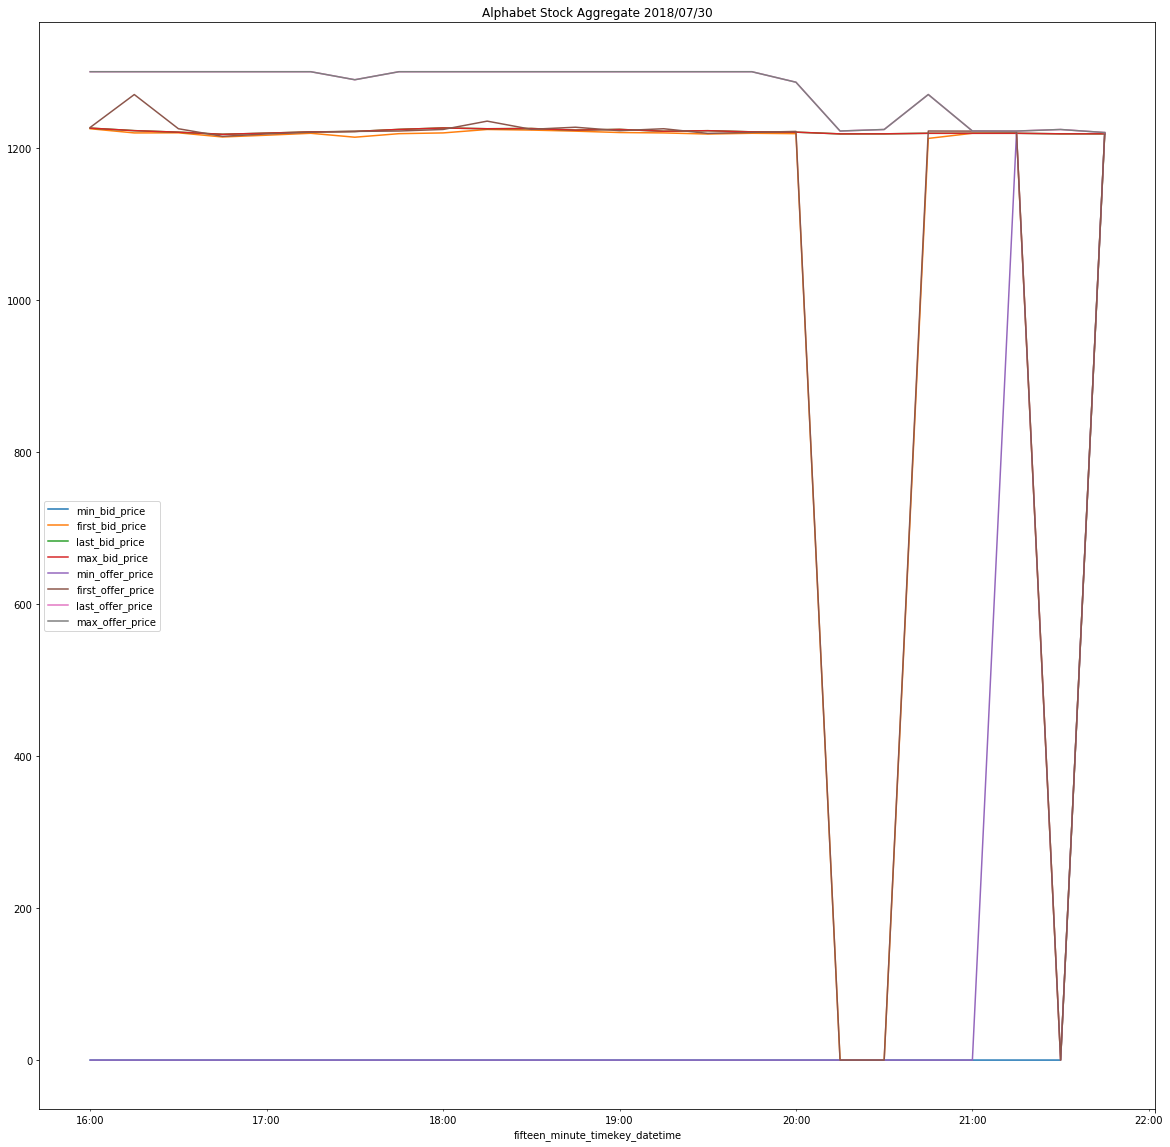

In [74]:
df.drop(['fifteen_minute_timekey', 'symbol_id', 'coords'], axis=1).plot(x='fifteen_minute_timekey_datetime', title='Alphabet Stock Aggregate 2018/07/30', figsize=(20, 20))

# Performing Aggregation via TileDB-Py instead of Presto

Here we will query the array and perform the same aggregation we did in Presto. One benefit of TileDB is its iteroperability. Data can be accessed directly from the TileDB Python API (or other language bindings) or through a SQL layer such as Presto. You are more comfortable with.

In [14]:
schema = tiledb.ArraySchema.load(ctx, quote_uri)
domain = schema.domain
pd.DataFrame([(domain.dim(i).name, domain.dim(i).dtype) for i in range(domain.ndim)], columns=("Dimension", "dtype"))

,Dimension,dtype
0,symbol_id,uint64
1,datetime,uint64
2,Sequence_Number,uint64


In [108]:
with tiledb.SparseArray(ctx, quote_uri, mode='r') as array:
    # Query to get 6 hours of data, datetime is stored as unix epoch nanoseconds, we use pandas to query via human readable string
    starttime = pd.to_datetime('2018-07-30 16:00:00').to_datetime64().astype('int64')
    endtime = pd.to_datetime('2018-07-30 22:00:00').to_datetime64().astype('int64')
    print("Querying with starttime={}, endtime={}".format(starttime, endtime))
    res = array.query(
        attrs=("Bid_Price", "Bid_Size", "Offer_Price", "Offer_Size"))[3377:3378, starttime:endtime, :]

Querying with starttime=1532966400000000000, endtime=1532988000000000000


In [90]:
res['symbol_id'] = np.ascontiguousarray(res['coords']['symbol_id'])
res['epoch_datetime'] = np.ascontiguousarray(res['coords']['datetime'])
res['Sequence_Number'] = np.ascontiguousarray(res['coords']['Sequence_Number'])
res['datetime'] = pd.to_datetime(res['epoch_datetime'])
res['fifteen_minute_timekey'] = res['epoch_datetime'] // (15*60*1000000000) * (15*60*1000000000)

In [91]:
df = pd.DataFrame(res)
df.count()

coords                    307767
Bid_Price                 307767
Bid_Size                  307767
Offer_Price               307767
Offer_Size                307767
symbol_id                 307767
datetime                  307767
Sequence_Number           307767
epoch_datetime            307767
fifteen_minute_timekey    307767
dtype: int64

In [92]:
df[0:10]

,coords,Bid_Price,Bid_Size,Offer_Price,Offer_Size,symbol_id,datetime,Sequence_Number,epoch_datetime,fifteen_minute_timekey
0,"(3377, 1532966400154453909, 14922335)",1225.000000,2,1226.719971,1,3377,2018-07-30 16:00:00.154453909,14922335,1532966400154453909,1532966400000000000
1,"(3377, 1532966400154474910, 14922337)",1225.000000,2,1226.540039,1,3377,2018-07-30 16:00:00.154474910,14922337,1532966400154474910,1532966400000000000
2,"(3377, 1532966400155049308, 14922338)",1218.630005,1,1226.599976,1,3377,2018-07-30 16:00:00.155049308,14922338,1532966400155049308,1532966400000000000
3,"(3377, 1532966400155229921, 14922339)",1218.630005,1,1226.599976,1,3377,2018-07-30 16:00:00.155229921,14922339,1532966400155229921,1532966400000000000
4,"(3377, 1532966400155558478, 14922341)",1218.630005,1,1226.599976,1,3377,2018-07-30 16:00:00.155558478,14922341,1532966400155558478,1532966400000000000
5,"(3377, 1532966400235815306, 14922608)",1218.630005,1,1226.599976,2,3377,2018-07-30 16:00:00.235815306,14922608,1532966400235815306,1532966400000000000
6,"(3377, 1532966400650016856, 14922970)",1222.569946,1,1226.689941,1,3377,2018-07-30 16:00:00.650016856,14922970,1532966400650016856,1532966400000000000
7,"(3377, 1532966400650231852, 14922971)",1222.569946,1,1226.689941,1,3377,2018-07-30 16:00:00.650231852,14922971,1532966400650231852,1532966400000000000
8,"(3377, 1532966401155378892, 14923681)",0.000000,0,1226.540039,1,3377,2018-07-30 16:00:01.155378892,14923681,1532966401155378892,1532966400000000000
9,"(3377, 1532966401187950243, 14923697)",1225.000000,3,1226.540039,1,3377,2018-07-30 16:00:01.187950243,14923697,1532966401187950243,1532966400000000000


Next we will perform the same operation as above via Pandas `groupby` functionality.

In [93]:
df.groupby(['symbol_id', 'fifteen_minute_timekey']).agg({'fifteen_minute_timekey': lambda x: pd.to_datetime(x.min()), 'epoch_datetime': ['min', lambda x: pd.to_datetime(x.min())], 'Bid_Price': ['first', 'last', 'min', 'max'], 'Offer_Price': ['first', 'last', 'min', 'max']})

fifteen_minute_timekey       epoch_datetime  \
                                               <lambda>                  min   
symbol_id fifteen_minute_timekey                                               
3377      1532966400000000000       2018-07-30 16:00:00  1532966400154453909   
          1532967300000000000       2018-07-30 16:15:00  1532967300135475405   
          1532968200000000000       2018-07-30 16:30:00  1532968200041997194   
          1532969100000000000       2018-07-30 16:45:00  1532969100653798970   
          1532970000000000000       2018-07-30 17:00:00  1532970000105612699   
          1532970900000000000       2018-07-30 17:15:00  1532970900263375161   
          1532971800000000000       2018-07-30 17:30:00  1532971800052890067   
          1532972700000000000       2018-07-30 17:45:00  1532972700041539622   
          1532973600000000000       2018-07-30 18:00:00  1532973600440703781   
          1532974500000000000       2018-07-30 18:15:00  1532974501480440393   
          1532975400000000000       2018-07-30 18:30:00  1532975400034812562   
          1532976300000000000       2018-07-30 18:45:00  1532976301084828284   
          1532977200000000000       2018-07-30 19:00:00  1532977200271835494   
          1532978100000000000       2018-07-30 19:15:00  1532978100009582794   
          1532979000000000000       2018-07-30 19:30:00  1532979000013305396   
          1532979900000000000       2018-07-30 19:45:00  1532979900095654624   
          1532980800000000000       2018-07-30 20:00:00  1532980800010436425   
          1532981700000000000       2018-07-30 20:15:00  1532981700002435377   
          1532982600000000000       2018-07-30 20:30:00  1532982622323553521   
          1532983500000000000       2018-07-30 20:45:00  1532983535234031351   
          1532984400000000000       2018-07-30 21:00:00  1532984456094172608   
          1532985300000000000       2018-07-30 21:15:00  1532985466862934152   
          1532986200000000000       2018-07-30 21:30:00  1532986834713966147   
          1532987100000000000       2018-07-30 21:45:00  1532987335943129931   

                                                                  Bid_Price  \
                                                      <lambda>        first   
symbol_id fifteen_minute_timekey                                              
3377      1532966400000000000    2018-07-30 16:00:00.154453909  1225.000000   
          1532967300000000000    2018-07-30 16:15:00.135475405  1219.479980   
          1532968200000000000    2018-07-30 16:30:00.041997194  1219.630005   
          1532969100000000000    2018-07-30 16:45:00.653798970  1214.160034   
          1532970000000000000    2018-07-30 17:00:00.105612699  1216.479980   
          1532970900000000000    2018-07-30 17:15:00.263375161  1219.020020   
          1532971800000000000    2018-07-30 17:30:00.052890067  1213.849976   
          1532972700000000000    2018-07-30 17:45:00.041539622  1218.500000   
          1532973600000000000    2018-07-30 18:00:00.440703781  1219.500000   
          1532974500000000000    2018-07-30 18:15:01.480440393  1224.020020   
          1532975400000000000    2018-07-30 18:30:00.034812562  1223.250000   
          1532976300000000000    2018-07-30 18:45:01.084828284  1221.819946   
          1532977200000000000    2018-07-30 19:00:00.271835494  1220.000000   
          1532978100000000000    2018-07-30 19:15:00.009582794  1219.500000   
          1532979000000000000    2018-07-30 19:30:00.013305396  1218.020020   
          1532979900000000000    2018-07-30 19:45:00.095654624  1219.030029   
          1532980800000000000    2018-07-30 20:00:00.010436425  1218.530029   
          1532981700000000000    2018-07-30 20:15:00.002435377     0.000000   
          1532982600000000000    2018-07-30 20:30:22.323553521     0.000000   
          1532983500000000000    2018-07-30 20:45:35.234031351  1212.270020   
          1532984400000000000    2018-07-30 21:00:56.09

There are a lot of 0's for minimum values in this aggregation, let's take a look at a plot of the raw data.

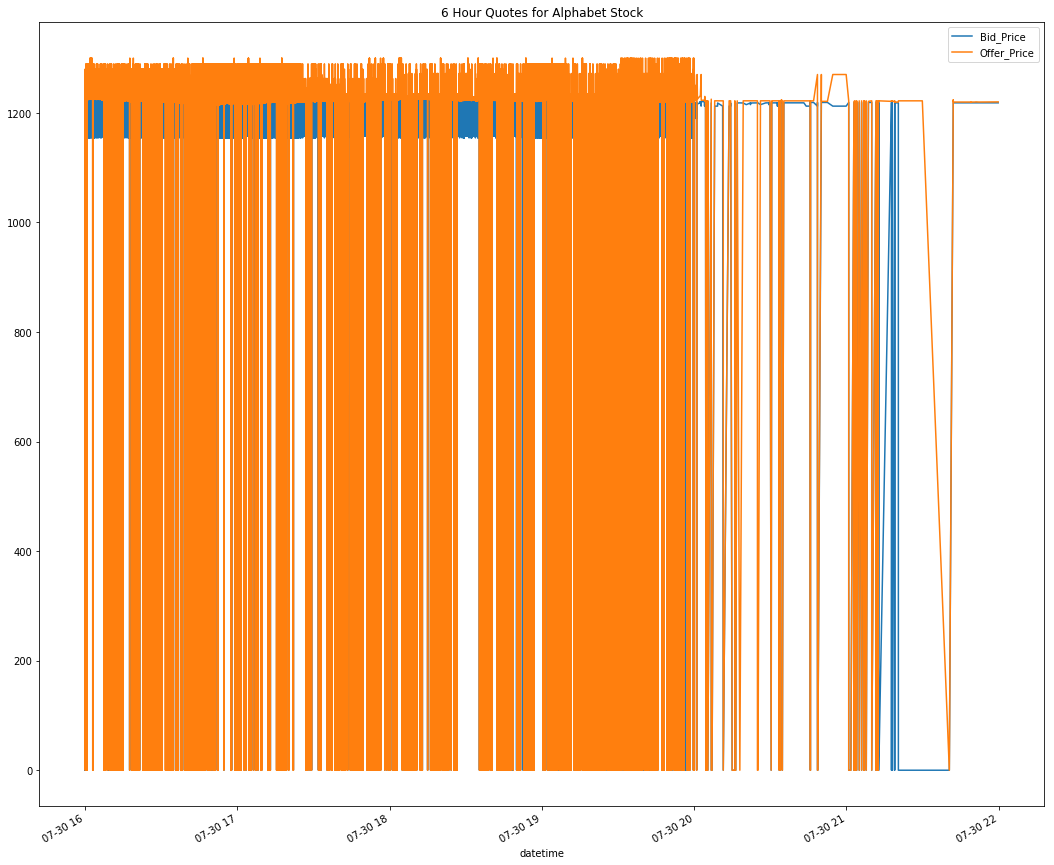

In [18]:
df.drop(['symbol_id', 'epoch_datetime', 'sequence_number', 'Offer_Size', 'Bid_Size', 'fifteen_minute_timekey'], axis=1).plot(x='datetime', title='6 Hour Quotes for Alphabet Stock', figsize=(18, 16))

## Removing Outliers with Pandas

The raw data graph shows the volume of 0 quotes, this happens where there is a bid with no offer, or an offer with no bid. Let's remove outliers via inter-quartile range method.

In [19]:
# Compute Offier Price IQR
OPQ1 = df['Offer_Price'].quantile(0.25)
OPQ3 = df['Offer_Price'].quantile(0.75)
OPIQR = OPQ3 - OPQ1
OP_lower = OPQ1 - 1.5 * OPIQR
OP_upper = OPQ3 + 1.5 * OPIQR
print("Offer_Price: Q1={}, Q3={}, IQR={}, lower={}, upper={}".format(OPQ1, OPQ3, OPIQR, OP_lower, OP_upper))

# Compute Bid Price IQR
BPQ1 = df['Bid_Price'].quantile(0.25)
BPQ3 = df['Bid_Price'].quantile(0.75)
BPIQR = BPQ3 - BPQ1
BP_lower = BPQ1 - 1.5 * BPIQR
BP_upper = BPQ3 + 1.5 * BPIQR
print("Bid_Price: Q1={}, Q3={}, IQR={}, lower={}, upper={}".format(BPQ1, BPQ3, BPIQR, BP_lower, BP_upper))

# Filtering Values to those that are inside the Bid/Offer price range
filtered = df.query('@OP_lower <= Offer_Price <= @OP_upper & @BP_lower <= Bid_Price <= @BP_upper')

Offer_Price: Q1=1220.06005859375, Q3=1225.0, IQR=4.93994140625, lower=1212.650146484375, upper=1232.409912109375
Bid_Price: Q1=1214.0, Q3=1220.0, IQR=6.0, lower=1205.0, upper=1229.0


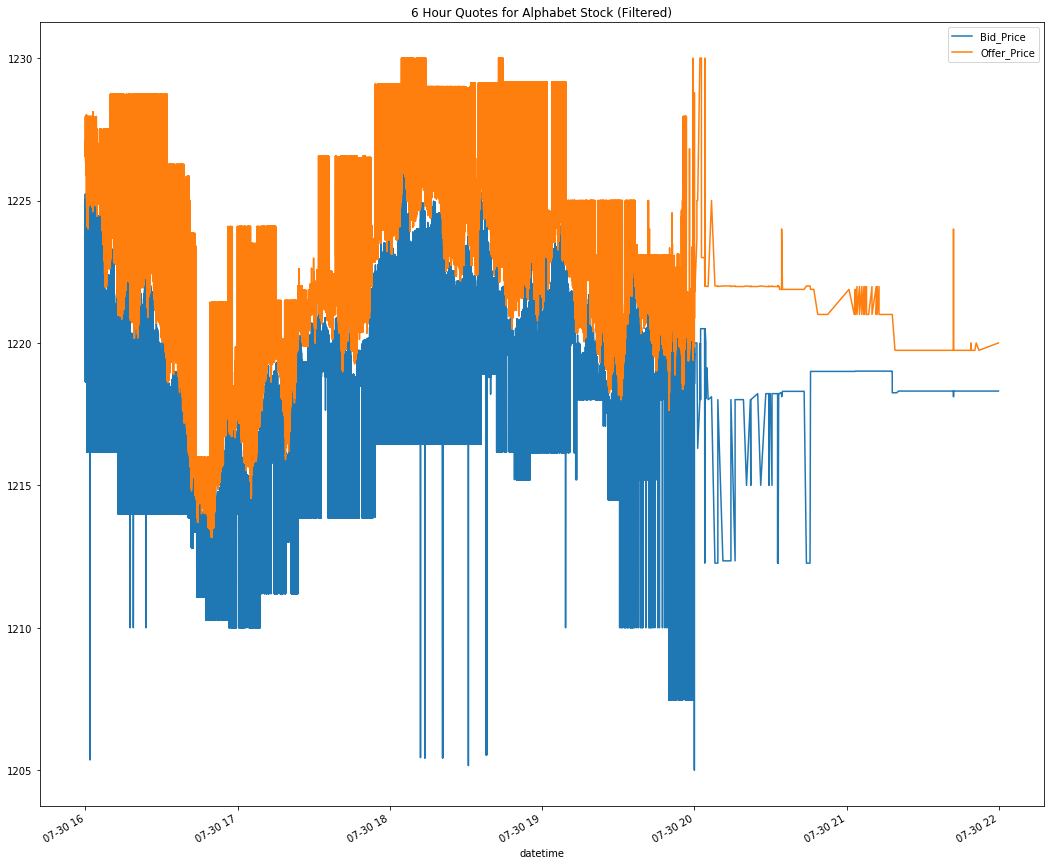

In [20]:
filtered.drop(['symbol_id', 'epoch_datetime', 'sequence_number', 'Offer_Size', 'Bid_Size', 'fifteen_minute_timekey'], axis=1).plot(x='datetime', title='6 Hour Quotes for Alphabet Stock (Filtered)', figsize=(18, 16))

# Conclusion

TileDB ingregation with Presto couples the power and flexiblity of SQL with TileDB's powerful array data format.

Presto can be used in a single instance for quick and easy SQL, or in a multi-node distributed environment for operating on large scale data. Presto is not the perfect solution for all use cases, as there is inherit overhead in the JVM, and limitations to the supported User Defined Functions (UDFs). Those limitations can typically be overcome by accessing TileDB arrays directly from your preferred programming langauge. TileDB offers integrations with a variaty of languages and is expanding its integrations even more, stay tuned!  